# Задание

Дана следующая задача: $(x−μ_0)^⊤A(x−μ_0) \to min$

При ограничении Евклидовой нормой: $∥x∥^2_2=∥x∥^2≤1$, что эквивалентно $(\sqrt{\sum_{i=1}^{n}|x_i|^2})^2=\sum_{i=1}^{n}x_i^2=x_1^2+...+x_n^2≤1$

Где: где $x∈R^n$, $A$ - симметричная, положительно определенная матрица, $μ_0= (1, 1, . . . , 1)^⊤∈R^n$.
1) Исследовать задачу на выпуклость.
2) Для каждого значения $n∈\{10, 20, ..., 100\}$ сгенерировать $N=100$ тестовых примеров. В каждом случае найдите глобальный минимум, $x^∗∈R^n$, с помощью CVX. Проверьте, что в точке минимума выполняется условие оптимальности (т.е. вектора градиента к ограничению и антиградиента к целевой функции сонаправлены).
3) Для каждого значения $n∈\{10, 20, ..., 100\}$ и для каждого тестового примера $N_i,\ i$ от 1 до 100 сгенерировать по $P=100$ начальных точек. В зависимости от варианта (v3) реализуйте следующие методы решения задачи для заданной точности $ε=0.01$ (Используйте в качестве точности либо разность между текущим значением функции и оптимальным (из солвера), либо некоторую меру выполнения условий оптимальности):
    * Gradient descent for strongly convex and Lipschitz functions ([Section 3.4.1, Theorem 3.9](https://arxiv.org/pdf/1405.4980#page=50));
    * Gradient descent for smooth functions ([Section 3.2, Theorem 3.7](https://arxiv.org/pdf/1405.4980#page=43));
    
    $\to$ Gradient descent for strongly convex and smooth functions ([Section 3.4.2, Theorem 3.12](https://arxiv.org/pdf/1405.4980#page=52));
    * Conditional gradient descent, aka Frank-Wolfe ([Section 3.3, Theorem 3.8](https://arxiv.org/pdf/1405.4980#page=45));
    * Exact line search ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477));
    * Backtracking line search  ([Section 9.2](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf#page=477)).
4) Объясните принцип работы метода, опишите его преимущества и недостатки.
5) В качестве результата работы метода:
    * Для каждого значения $n∈\{10, 20, ..., 100\}$ подсчитайте среднее время работы метода и среднее число итераций (усреднение проводится по всем начальным точкам и по всем тестовым примерам);
    * Для одного тестового примера при $n=10$ и нескольких различных начальных точек постройте зависимость точности от числа итераций. Зависит ли скорость сходимости метода от отношения максимального и минимального собственных чисел матрицы A? Сравните полученные результаты с теоретическими верхними оценками (толькодля вариантов 1-4, обратите внимание, что для сравнения с теоретическими верхними оценками необходимо считать точность тем же способом, как это делается в соответствующей оценке).
6) Оформите отчет с последовательным изложением пунктов 1-5 и выводами.

# Настройки/Импорты

Версии важных модулей:
cvxpy==1.4.3

In [1]:
import cvxpy as cp # солвер для задач
import numpy as np # для работы с массивами
from sklearn.datasets import make_spd_matrix # для генерации симметричной положительно определённой матрицы A для поставленной задачи

import time # для отслеживания времени выполнения
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

In [2]:
n = np.arange(10, 101, 10) # возможные значения n (число переменных в задаче ~ размерность пространства) от 10 до 100 включительно
N = 100 # число тестовых примеров для каждого значения n
P = 100 # число начальных точек для каждого примера N
ε = 0.01 # необходимая точность

# Вспомогательные функции

In [3]:
def func(x: np.array, A: np.array, μ: np.array) -> np.float32:
    """
    Функция из задачи (значение x в виде столбца!).\n
    Parameters:
        * x: текущие значения x
        * A: матрица A
        * μ: смещение центра функции\n
    Returns:
        * np.float32: значение функции в точке x
    """
    return (x-μ).T @ A @ (x-μ) # значение функции задачи (было бы (x-μ) @ A @ (x-μ).reshape((dim,1)), если бы x шёл как строка, а не столбец)

In [4]:
def func_grad(x: np.array, A: np.array, μ: np.array) -> np.array:
    """
    Производная функции из задачи (значение x в виде столбца!).\n
    Parameters:
        * x: текущие значения x
        * A: матрица A
        * μ: смещение центра функции\n
    Returns:
        * np.float32: значение функции в точке x
    """
    return 2 * A @ (x - μ) # значение производной функции задачи
    # return 2 * A @ x # значение производной функции задачи

In [5]:
def constraints(x: np.array) -> bool:
    """
    Функция для проверка решения на допустимость.\n
    Parameters:
        * x: текущие значения x\n
    Returns:
        * bool: True — если решение допустимо, иначе — False
    """
    return np.linalg.norm(x, ord=2) ** 2 <= 1 # квадрат евклидовой нормы решения должен быть ≤ 1

In [6]:
def constraints_grad(x: np.array) -> np.float32:
    """
    Производная функции ограничения из задачи.\n
    Parameters:
        * x: текущие значения x\n
    Returns:
        * np.float32: значение производной функции ограничения в точке x
    """
    return 2 * x 

In [7]:
def optimal(x: np.array, A: np.array, μ: np.array) -> bool:
    """
    Функция для проверки оптимальности решения. Необходимо, чтобы вектора градиента к ограничению и антиградиента к целевой функции были сонаправлены. 
    Для проверки сонаправленности необходимо, чтобы вектора были коллинеарны (x1/y1 = x2/y2 = ... = xn/yn) и их скалярное произведение (dot product) было положительным.\n
    Parameters:
        * x: текущие значения x
        * A: матрица A
        * μ: смещение центра функции\n
    Returns:
        * bool: True — если решение оптимально, False — иначе
    """
    grad_const = constraints_grad(x) # значение вектора градиента ограничений
    grad_func = func_grad(x, A, μ) # значение вектора градиента функции

    # relation = grad_const / grad_func # отношение (x1/y1, x2/y2, ..., xn/yn) для проверки коллинеарности 
    # assert np.isclose(relation, relation[0], atol=0.1).all(), "Вектора не коллинеарны!" # если не все значения (x1/y1, x2/y2, ..., xn/yn) совпадают с точностью до atol — выкидываем ошибку

    return grad_const.T @ -grad_func > 0 # проверка сонаправленнсоти (скалярное произведение вектора градиента к ограничению и антиградиента к целевой функции положительно)

In [8]:
def dist(x_1: np.array, x_2: np.array) -> np.float32:
    """Функция для подсчёта Евклидового расстояния между точками.\n
    Parameters:
        * x_1: от какой точки считать
        * x_2: до какой точки считать\n
    Returns:
        * np.float32: дистанция до точки
    """
    # return np.linalg.norm(x_2 - x_1, ord=2) # считаем Евклидово расстояние
    return ((x_2 - x_1)**2).sum()**(1/2) # считаем Евклидово расстояние (корень из суммы квадратов разности координат точек)

# 1) Исследование на выпуклость

Данная функция $(x−μ_0)^⊤A(x−μ_0)$ — квадратичная. Она выпукла тогда и только тогда, когда матрица $A$ — положительно определена, то есть по критерию Сильвестра — когда все её угловые миноры $\Delta_i$ положительны. Согласно условию задания матрица $A$ уже симметричная и положительно определённая — поэтому функция является выпуклой.

Примеры:
* Если $n=2$, функция будет иметь следующий вид (квадратичный):<br>
    $a_{11}(x_1-μ_1)^2+a_{22}(x_2-μ_2)^2+2a_{12}(x_1-μ_1)(x_2-μ_2) \to min$

    А её ограничение:<br>
    $x_1^2+x_2^2≤1$

    Пусть $A$ — $\begin{bmatrix} 5 & 3 \\ 3 & 5 \end{bmatrix}$, $μ_0= (1, 1)^T$. Тогда график функции (эллипсоид) вместе с ограничением примет следующий вид:<br>
    ![Пример в 2D](./images/example_2d.png)

* Если $n=3$, функция будет иметь следующий вид (квадратичный):<br>
    $a_{11}(x_1-μ_1)^2+a_{22}(x_2-μ_2)^2+a_{33}(x_3-μ_3)^2+2a_{12}(x_1-μ_1)(x_2-μ_2)+2a_{13}(x_1-μ_1)(x_3-μ_3)+2a_{23}(x_2-μ_2)(x_3-μ_3) \to min$

    А её ограничение:<br>
    $x_1^2+x_2^2+x_3^2≤1$

    Пусть $A$ — единичная матрица, то есть на её диагонали стоят единицы, а всё остальное — нули (такая матрица положительно определена), $μ_0= (1, 1, 1)^T$. Тогда часть функции без квадратов занулится и её график (станет сферой, иначе — эллипсоид) вместе с ограничением примет следующий вид:<br>
    ![Пример в 3D](./images/example_3d.png)

# 2) Генерация и решение тестовых примеров с помощью встроенных методов.

**Важно: в CVX по стандарту переменные идут не в виде столбца, а в виде строки. Однако, при желании можно заменить shape=(dim) на shape=(dim, 1) чтобы всё было как в обычной математике.**

In [9]:
data = {} # словарь под данные для теста

for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    data[dim] = dict.fromkeys(range(N), {}) # подсловарь под тест-кейсы для рассматриваемой размерности dim (получилась тройная вложенность словаря)
    for i in range(N): # идём по числу тест-кейсов
        # решаем задачу с помощью солвера
        A = make_spd_matrix(n_dim=dim) # генерируем случайную симметричную положительно определённую матрицу A
        x = cp.Variable(shape=(dim, 1)) # значения переменных 
        μ = np.ones(shape=(dim, 1)) # смещение центра функции
        objective = cp.Minimize(cp.quad_form(x-μ, A)) # минимизируем квадратичную функцию
        # objective = cp.Minimize((x-μ).T @ A @ (x-μ)) # как должно быть с обычной математикой (не запустить, так как CVX считает такую проблему не выпуклой)
        constraints = [cp.sum_squares(x) <= 1] # накладываемое ограничение — сумма квадратов переменных меньше или равна 1
        problem = cp.Problem(objective, constraints) # создаём объект решаемой задачи
        res = problem.solve(solver=cp.ECOS) # решаем поставленную проблему с помощью solver

        optimal(x.value, A, μ) # проверяем решение на оптимальность

        data[dim][i]["A"] = A # запоминаем матрицу A
        data[dim][i]["X opt solver"] = x.value # оптимальное значение X от встроенного солвера
        data[dim][i]["Result solver"] = res # ответ от встроенного солвера

100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


In [10]:
data[10][0] # тест-кейс 0 для для 10 переменных

{'A': array([[ 5.49133987e-01, -2.24667154e-01, -1.73665950e-01,
         -2.89014418e-02, -6.70717229e-02, -1.00592752e-01,
         -1.57380072e-01, -1.14348985e-02, -1.75008165e-01,
          2.90856601e-01],
        [-2.24667154e-01,  3.39849575e+00,  1.25895656e+00,
          9.98659836e-01,  6.62031087e-01, -3.41093097e-01,
          5.70738851e-01,  9.44479076e-01,  2.23909943e+00,
         -3.47741729e+00],
        [-1.73665950e-01,  1.25895656e+00,  9.49288422e-01,
          3.32292486e-01,  3.86391002e-01, -1.42642348e-01,
          1.75919483e-01,  2.30883668e-01,  7.23756488e-01,
         -1.43319535e+00],
        [-2.89014418e-02,  9.98659836e-01,  3.32292486e-01,
          6.79913474e-01,  7.38805258e-02, -4.95402316e-02,
          1.18889264e-01,  1.63972165e-01,  5.12275315e-01,
         -1.08443984e+00],
        [-6.70717229e-02,  6.62031087e-01,  3.86391002e-01,
          7.38805258e-02,  5.43431512e-01, -9.17097784e-03,
          6.24459237e-02,  4.44845334e-02,  6.8

# 3) Реализация и тестирование градиентного спуска для строго выпуклых и гладких функций (Gradient descent for strongly convex and smooth functions with projection).

**Определения:**
1) Функция $f(x)$ называется ***α-strongly convex*** (строго выпуклой с параметром *α > 0*), если для $∀x ∈ dom(f)$ выполняется: $f(x)-\frac{α}{2}∥x∥^2$ — выпукла. <br>
Или, что аналогично, $(∇f(x) − ∇f(y))^T(x-y)≥α∥x-y∥^2$. Для дважды дифференцируемых функций это означает, что $\lambda_{min}(∇^2f(x))≥α$.
2) Непрерывно дифференцируемая функция $f(x)$ называется ***β-smooth*** (гладкой с параметром *β*), если её градиент $∇f$ — *β-Липшицев*. <br>
То есть если она обладает Липшицевым градиентом с константой *β*: $∥∇f(x) − ∇f(y)∥ ≤ β∥x − y∥$. Для дважды дифференцируемых функций это означает, что $\lambda_{max}(∇^2f(x))≤β$.

Strong convexity (строгая выпуклость) даёт нижнюю оценку кривизны функции значением *α*. Другими словами, все собственные значения Гессиана α-strongly convex function ограничены снизу величиной *α*. <br>
*β-smoothness* ограничивает кривизну функции (изменение градиента) некоторой константой *β*. Это эквивалентно тому, что собственные значения Гессиана меньше *β*. <br>
Объединив свойства *α-strongly convex* и *β-smooth* функций получаем, что собственные значения Гессиана находятся в области $α ≤ ∇^2f(x) ≤ β$.

***Теорема:*** Если $f$ это *β-smooth* и *α-strongly convex function* на $R^n$. Тогда градиентный спуск с шагом $η = \frac{2}{α+β}$ удовлетворяет выражению (скорость сходимости) <br>
$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.

В рассматриваемой задаче $f(x)=(x−μ_0)^⊤A(x−μ_0) \to min$ градиент функции $f(x)$ есть: <br> 
* $∇f(x) = 2A(x-μ_0)$

Гессиан же есть матрица $2A$: <br>
* $∇^2f(x) = 2A$

Градиент ограничения $C = x_1^2+...+x_n^2 ≤ 1$: <br>
* $∇C(x) = 2x$

Параметр *α* строгой выпуклости считается по формуле:
* $α = 2\lambda_{min}(A)$

Параметр *β* гладкости считается по формуле:
* $β = 2\lambda_{max}(A)$.

In [15]:
def gradient_descent(x: np.array, A: np.array, res_solver: np.float32, ε: np.float32, iteration_limit=None) -> list:
    """
    Метод градиентного спуска для подсчёта оптимума заданной функции.\n
    Parameters:
        * x: изначальное значение x
        * A: матрица A
        * res_solver: уже полученный ответ от солвера, к которому нужно сойтись
        * ε: необходимая точность ответа
        * iteration_limit: лимит числа итераций\n
    Returns:
        * list: [оптимальное значение функции, оптимальная точка x, число итераций]
    """
    iterations = 0 # счётчик итераций градиентного спуска

    # считаем шаг для функции
    eigenvalues = np.linalg.eigvals(A) # собственные значения матрицы A
    α = 2 * eigenvalues.min() # параметр выпуклости функции, в данном случае равен 2 * минимальное собственное значение матрицы A
    β = 2 * eigenvalues.max() # параметр гладкости функции, в данном случае равен 2 * максимальное собственное значение матрицы A
    η = 2 / (α + β) # значение шага

    dim = x.shape[0] # размерность пространства
    μ = np.ones(shape=(dim, 1)) # смещение центра функции, (dim, 1) — в виде столбца
    constraint_center = np.zeros(shape=(dim, 1)) # координаты центра сферы-ограничения задачи

    res_grad = func(x, A, μ) # значение начального решения метода градиентного спуска для рассматриваемой стартовой точки
    while abs(res_solver - res_grad) > ε: # пока не сошлись с ответом солвера
        x = x - η * func_grad(x, A, μ) # обновляем значение x
        if dist(constraint_center, x) > 1: # если нарушили ограничение ~ вышли из допустимой области (Евклидово расстояние от нуля до точки должно быть <= 1)
            x = x / dist(constraint_center, x) # берём проекцию точки на dim-мерную сферу (делим координаты на расстояние до точки, чтобы новое расстояние было равно 1)
        res_grad = func(x, A, μ)[0] # считаем значение функции
        iterations += 1 # увеличиваем общее число итераций на рассматриваемой размерности dim

    return [res_grad, x, iterations] # возвращаем [оптимальное значение функции, оптимальная точка x, число итераций]

In [16]:
for dim in tqdm(n): # идём по возможному числу переменных (размерности пространства)
    iterations = 0 # всего итераций для решения всех тест-кейсов при всех начальных точках
    time_start = time.time() # замеряем время старта рассмотрения размерности dim

    for i in range(N): # идём по числу тест-кейсов
        A = data[dim][i]["A"] # матрица А для тест-кейса

        res_solver = data[dim][i]["Result solver"] # результат от солвера для тест-кейса
        for p in range(P): # идём по числу случайных стартовых точек
            # ограничение задачи — квадрат евклидовой нормы вектора x ≤ 1
            x = np.random.randint(low=0, high=100, size=(dim, 1)) # генерируем случайные числа размера количества переменных (изначально они могут нарушать ограничения)
            x = x/np.linalg.norm(x, ord=2) # делим значение сгенерированного вектора на его евклидову норму, чтобы новая норма была точно ≤ 1 (на самом деле она будет лишь слегка меньше 1, но такая точка уже не нарушает ограничение задачи)

            iterations += gradient_descent(x, A, res_solver, ε)[2] # запоминаем число итераций, что потребовалось градиентному спуску чтобы сойтись с ответом солвера с точностью ε

    data[dim]["Average time"] = (time.time() - time_start) / (N * P) # среднее время для размерности dim за (N * p) решённых вариантов задачи
    data[dim]["Average iterations"] = iterations / (N * P) # среднее число итерации для размерности dim за (N * p) решённых вариантов задачи

100%|██████████| 10/10 [04:31<00:00, 27.18s/it]


# 4) Принцип работы метода "Gradient descent for α-strongly convex and β-smooth functions with projection"

1) Генерируем случайное начальное решение $x$;
2) Идём в сторону, противоположную градиенту $∇f(x)$ с шагом $η$ (в данному варианте $η = \frac{2}{α+β}$), так как он направлен в сторону наискорейшего роста, а нам нужно обратное — минимизировать функцию: $x_{t+1} = x_{t} - η * ∇f(x_{t})$;
3) Если вышли за допустимую область $X$ (нарушили ограничение) — обновляем $x_{t+1}$ по формуле: $x_{t+1}=argmin_{x'∊X}∥x_{t+1}-x'∥$, то есть ищем ближайшую точку $x'$ в допустимом множестве $X$. В данном случае просто берём проекцию точки на *n*-мерную сферу; <br>
![Шаг метода](./images/iteration.png)
4) Повторить с шага 2, пока значение функции $f(x)$ существенно уменьшается или не достигнут лимит итераций градиентного спуска.

***Преимущества***:
* Благодаря условию, что рассматриваемая функция ***α-strongly convex*** и ***β-smooth*** — шаг для градиентного спуска $η = \frac{2}{α+β}$ и скорость сходимости ограничена выражением: <br>
$f(x_{t+1}) − f(x^∗) ≤ \frac{β}{2}e^{−\frac{4t}{k+1}}∥x_1-x^*∥^2$, где $k=\frac{β}{α}$.

***Недостатки***:
* Требует, чтобы у функции существовала производная 
* Градиентный спуск может застрять на локальном минимуме.

# 5) Результаты работы метода

### Среднее время и число итераций градиентного спуска

In [20]:
average_times = [] # список под значения среднего времени
average_iterations = [] # список под значения среднего числа итераций
for dim in n: # идём по возможному числу переменных (размерности пространства)
    average_times.append(data[dim]["Average time"])
    average_iterations.append(data[dim]["Average iterations"])

C:\Users\User\Documents\TEMP\ipykernel_13696\3546275075.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
C:\Users\User\Documents\TEMP\ipykernel_13696\3546275075.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')


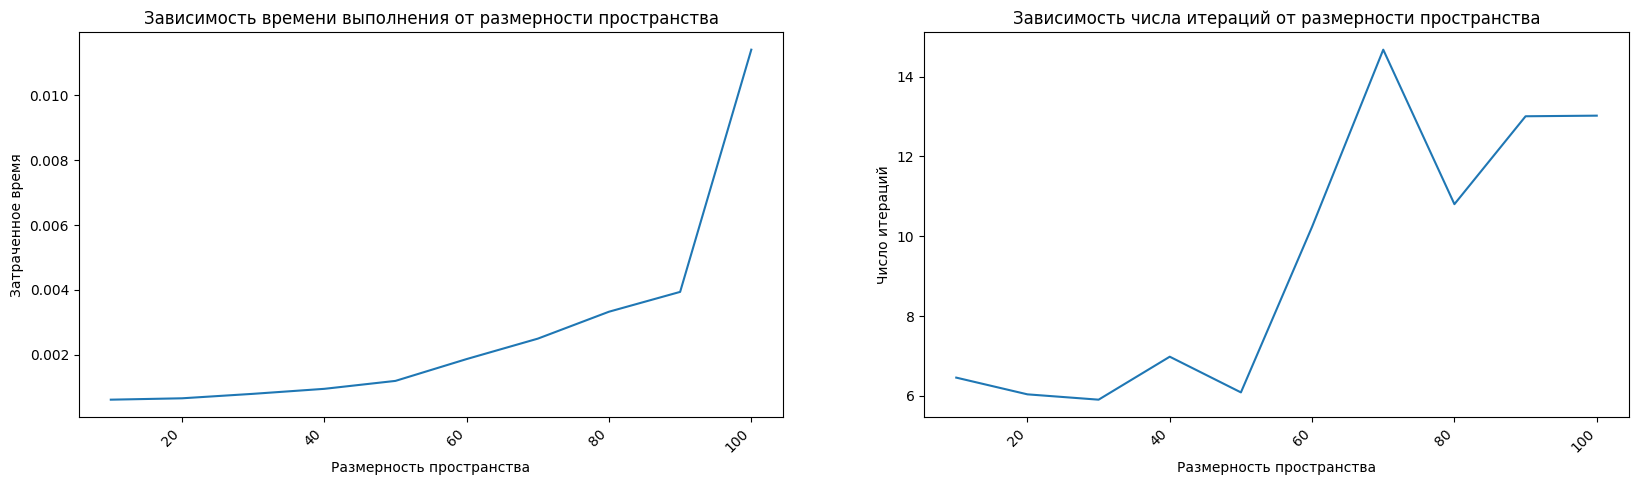

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(20,5)) # создаём фигуру с несколькими подграфиками (ncols и/или nrows) размера figsize

axes[0].plot(n, average_times) # построение графика на оси ax
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[0].set_title("Зависимость времени выполнения от размерности пространства") # название фигуры
axes[0].set_xlabel("Размерность пространства") # подпись по оси OX
axes[0].set_ylabel("Затраченное время") # подпись по оси OY

axes[1].plot(n, average_iterations) # построение графика на оси ax
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
axes[1].set_title("Зависимость числа итераций от размерности пространства") # название фигуры
axes[1].set_xlabel("Размерность пространства") # подпись по оси OX
axes[1].set_ylabel("Число итераций") # подпись по оси OY

plt.show() # показ фигуры

In [ ]:
X = [] # список под значения переменных x
Y = [] # список под значения целевой функции

In [ ]:
y = func(x, A, μ)[0] # считаем начальное значение функции
X.append(x) # запоминаем начальную точку (всегда будет идти под индексом 0)
Y.append(y) # запоминаем начальное решение

while constraints(x):
    x = x - η * func_grad(x, A, μ) # обновляем значение x
    y = func(x, A, μ)[0] # считаем начальное значение функции
    X.append(x) # запоминаем начальную точку (всегда будет идти под индексом 0)
    Y.append(y) # запоминаем начальное решение